# Sound-evoked neural responses during oddball paradigm

Here we will evaluate the responses of neurons to sound stimuli, by extracting a window of the fluorescence signal around the time of each stimulus.

In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys

First, a function we will need to extract windows around each stimulus onset.

In [35]:
def lock_to_event(signal, srate, eventOnsetTime, timeRange):
    """
    Extracts a window of signal around each event.

    Args:
        signal (numpy.ndarray): The input signal.
        srate (float): The sampling rate of the signal.
        eventOnsetTime (numpy.ndarray): Array of event onset times (in seconds).
        timeRange (tuple): Time window (start, end) to extract around the event.

    Returns:
        numpy.ndarray: 2D array where each row corresponds to a trial,
            and each column corresponds to a sample within the specified time range.
        numpy.ndarray: Time vector corresponding to the columns in the locked signal.

    Note:
        If there are not enough samples to extract within the specified time range for an event,
        the corresponding row in the locked signal array will be filled with NaN values.
    """
    samplesVec = np.arange(int(timeRange[0]*srate),
                           int(timeRange[-1]*srate))
    timeVec = samplesVec/srate
    nSamples = len(timeVec)
    nTrials = len(eventOnsetTime)
    eventOnsetSamples = np.round(eventOnsetTime*srate).astype(int)
    lockedSignal = np.empty((nTrials, nSamples))
    for inde, eventSample in enumerate(eventOnsetSamples):
        try:
            lockedSignal[inde,:] = signal[samplesVec+eventSample]
        except IndexError:
            # Do this if there are not enough samples to get will window
            lockedSignal[inde,:] = np.full(nSamples, np.nan)
    return (lockedSignal, timeVec)


Let's load the data. This requires you have generated the `soundID.npz` (as described in the notebook `oddball_fm_sound_identity.ipynb`)

In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys

srate2p = 11.16  # According to Evan
srateSound = 50000  # According to Evan

dataPath = '/data/mesoscope/6998_231122_E295/fm_3_pre_doi/'
suite2pPath = 'suite2p/combined/'

spks = np.load(os.path.join(dataPath, suite2pPath, 'spks.npy'), allow_pickle=True)

soundID = np.load(os.path.join(dataPath, 'soundID.npz'), allow_pickle=True)
soundOnsetInSamples = soundID['onsetInds']
sweepDirection = soundID['sweepDirection']
sweepDirectionLabels = soundID['sweepDirectionLabels'].item()

Let's plot the neural data:

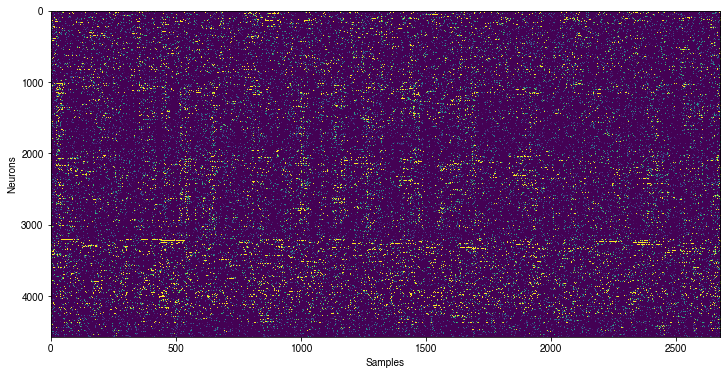

In [37]:
plt.figure(figsize=(12,6))
plt.imshow(spks, vmax=100, interpolation='nearest')
plt.xlabel('Samples')
plt.ylabel('Neurons');

Let's verify that the duration of the imaging data matches that of the sound onsets:

In [38]:
sessionDuration = spks.shape[1]/srate2p  # In seconds
soundOnset = soundOnsetInSamples/srateSound # In seconds
print(f'Imaging session: {sessionDuration/60:0.2f} min')
print(f'Last sound onset: {soundOnset[-1]/60:0.2f} min')

Imaging session: 4.00 min
Last sound onset: 21.11 min


**Warning!** It looks like the imaging session is 4min, but we have sound onsets for >20 min

# Make some risky assumptions and continue...

I'll assume the first 4 minutes of sound onsets corresponds to the imaging session.

In [39]:
soundOnsetInSamplesThisSession = soundOnsetInSamples[soundOnsetInSamples/srateSound < sessionDuration]
soundOnset = soundOnsetInSamplesThisSession/srateSound # In seconds

Let's extract a window around each stimulus and plot the signals for a few cells. 

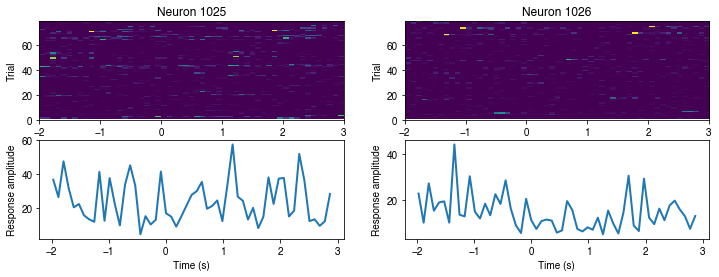

In [40]:
timeRange = [-2, 3]  # In seconds
nTrials = len(soundOnset)
neuronsToPlot = [1025, 1026]

plt.figure(figsize=(12,4))
for indn, neuronInd in enumerate(neuronsToPlot):
    lockedSignal, timeVec = lock_to_event(spks[neuronInd,:], srate2p, soundOnset, timeRange)
    plt.subplot(2, len(neuronsToPlot), indn+1)
    plt.imshow(lockedSignal, interpolation='nearest', extent=[*timeRange, 0, nTrials])
    #plt.xlabel('Time (s)')
    plt.ylabel('Trial')
    plt.title('Neuron {}'.format(neuronInd))
    
    plt.subplot(2, len(neuronsToPlot), indn+1+len(neuronsToPlot))
    plt.plot(timeVec, np.nanmean(lockedSignal, axis=0), lw=2)
    plt.xlabel('Time (s)')
    plt.ylabel('Response amplitude')